In [129]:
# from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import imgaug.augmenters as iaa
import random
import cv2

In [130]:
aug = False
plot = True if not aug else False

In [131]:
random_state = 42
random.seed(random_state)

aug_seq = iaa.Sequential([
            iaa.Rotate((-10, 10), random_state=random_state),                 
            iaa.ShearX((-10, 10), random_state=random_state),                  
            iaa.ShearY((-10, 10), random_state=random_state),
        ])

def augment(image):
    kernel = np.ones((2, 2), np.uint8) 
    # if random.random() < 0.5:
    #     image = cv2.erode(image, kernel, iterations=1) 
    # else:
    #     image = cv2.dilate(image, kernel, iterations=1) 
    image = aug_seq.augment_image(image)
    return image

In [132]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, gan_train, y_train, gan_y_train = train_test_split(x_train, y_train, test_size=0.5, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify=y_train)
gan_train, gan_val, gan_y_train, gan_y_val = train_test_split(gan_train, gan_y_train, test_size=0.1, random_state=42, stratify=gan_y_train) 

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.

if aug:
    x_train_aug = np.array([augment(x) for x in x_train.astype("float32")])
    x_train = np.concatenate([x_train, np.array(x_train_aug)])
    y_train = np.concatenate([y_train, y_train])

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.keras.utils.to_categorical(y_train, 10)

x_val = x_val.astype("float32") / 255.0
x_val = np.reshape(x_val, (-1, 28, 28, 1))
y_val = tf.keras.utils.to_categorical(y_val, 10)

gan_train = gan_train.astype("float32") / 255.0
# gan_train = np.reshape(gan_train, (-1, 28, 28, 1))
gan_y_train = tf.keras.utils.to_categorical(gan_y_train, 10)

gan_val = gan_val.astype("float32") / 255.0
# gan_val = np.reshape(gan_val, (-1, 28, 28, 1))
gan_y_val = tf.keras.utils.to_categorical(gan_y_val, 10)

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.keras.utils.to_categorical(y_test, 10)

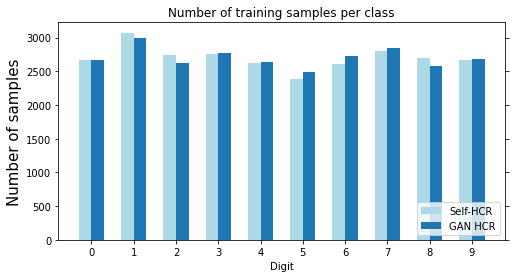

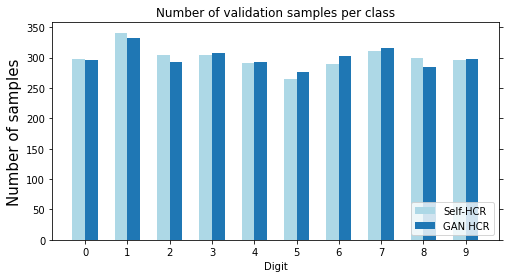

In [133]:
if plot:
	plt.rcParams['figure.figsize'] = [8, 4]
	fig, ax = plt.subplots(nrows=1, ncols=1)

	_, train_counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
	_, val_counts = np.unique(np.argmax(y_val, axis=1), return_counts=True)
	_, gan_train_counts = np.unique(np.argmax(gan_y_train, axis=1), return_counts=True)
	_, gan_val_counts = np.unique(np.argmax(gan_y_val, axis=1), return_counts=True)

	barWidth = 0.3
	br1 = np.arange(len(train_counts)) 
	br2 = [x + barWidth for x in br1] 

	ax.bar(br1, train_counts, width=barWidth, color='lightblue', label="Self-HCR")
	ax.bar(br2, gan_train_counts, width=barWidth, label="GAN HCR")
	# ax.set_xticklabels(labels=[i for i in range(10)])
	ax.tick_params(left = True, right = True , labelleft = True , 
					labelbottom = True, bottom = True) 
	plt.xticks([r + (barWidth/2) for r in range(len(train_counts))], 
			['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
	plt.ylabel('Number of samples', fontsize = 15) 
	plt.xlabel('Digit')
	plt.title('Number of training samples per class')
	plt.savefig('./datavis/classbal_mnist_training.png', dpi=300)
	plt.legend(loc="lower right")
	plt.show()

	plt.rcParams['figure.figsize'] = [8, 4]
	fig, ax = plt.subplots(nrows=1, ncols=1)

	barWidth = 0.3
	br1 = np.arange(len(val_counts)) 
	br2 = [x + barWidth for x in br1] 

	ax.bar(br1, val_counts, width=barWidth, color='lightblue', label="Self-HCR")
	ax.bar(br2, gan_val_counts, width=barWidth, label="GAN HCR")
	# ax.set_xticklabels(labels=[i for i in range(10)])
	ax.tick_params(left = True, right = True , labelleft = True , 
					labelbottom = True, bottom = True) 
	plt.xticks([r + (barWidth/2) for r in range(len(train_counts))], 
			['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
	plt.ylabel('Number of samples', fontsize = 15) 
	plt.xlabel('Digit')
	plt.title('Number of validation samples per class')
	plt.savefig('./datavis/classbal_mnist_validation.png', dpi=300)
	plt.legend(loc="lower right")
	plt.show()

### Checking the data

In [134]:
if plot:
	tsne = TSNE(n_components=2)
	x_train_tsne_results = tsne.fit_transform(x_train.reshape(x_train.shape[0], 28*28))
	x_val_tsne_res = tsne.fit_transform(x_val.reshape(x_val.shape[0], 28*28))

	gan_train_tsne_results = tsne.fit_transform(gan_train.reshape(gan_train.shape[0], 28*28))
	gan_val_tsne_res = tsne.fit_transform(gan_val.reshape(gan_val.shape[0], 28*28))

/Users/lisakoopmans/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/lisakoopmans/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/lisakoopmans/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/lisakoopmans/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/lisakoopmans/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from

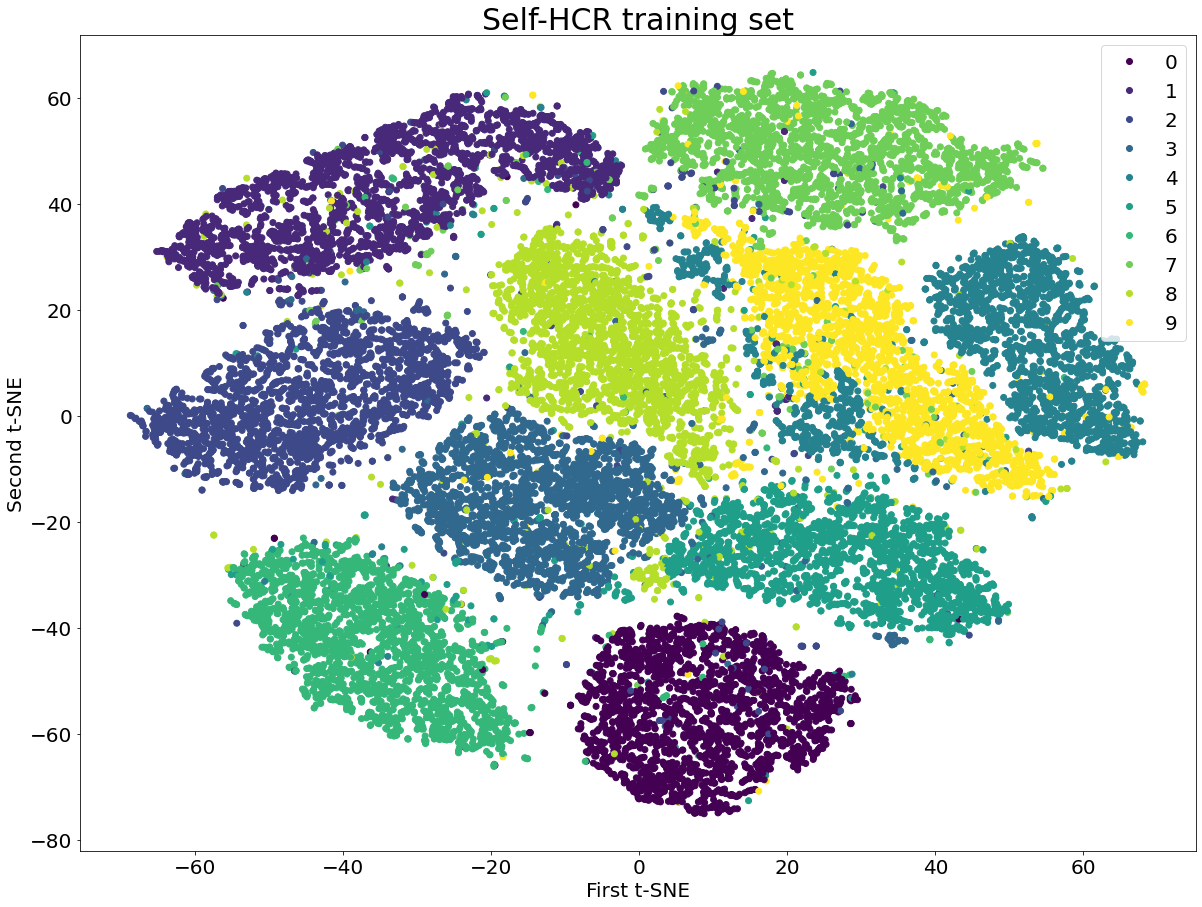

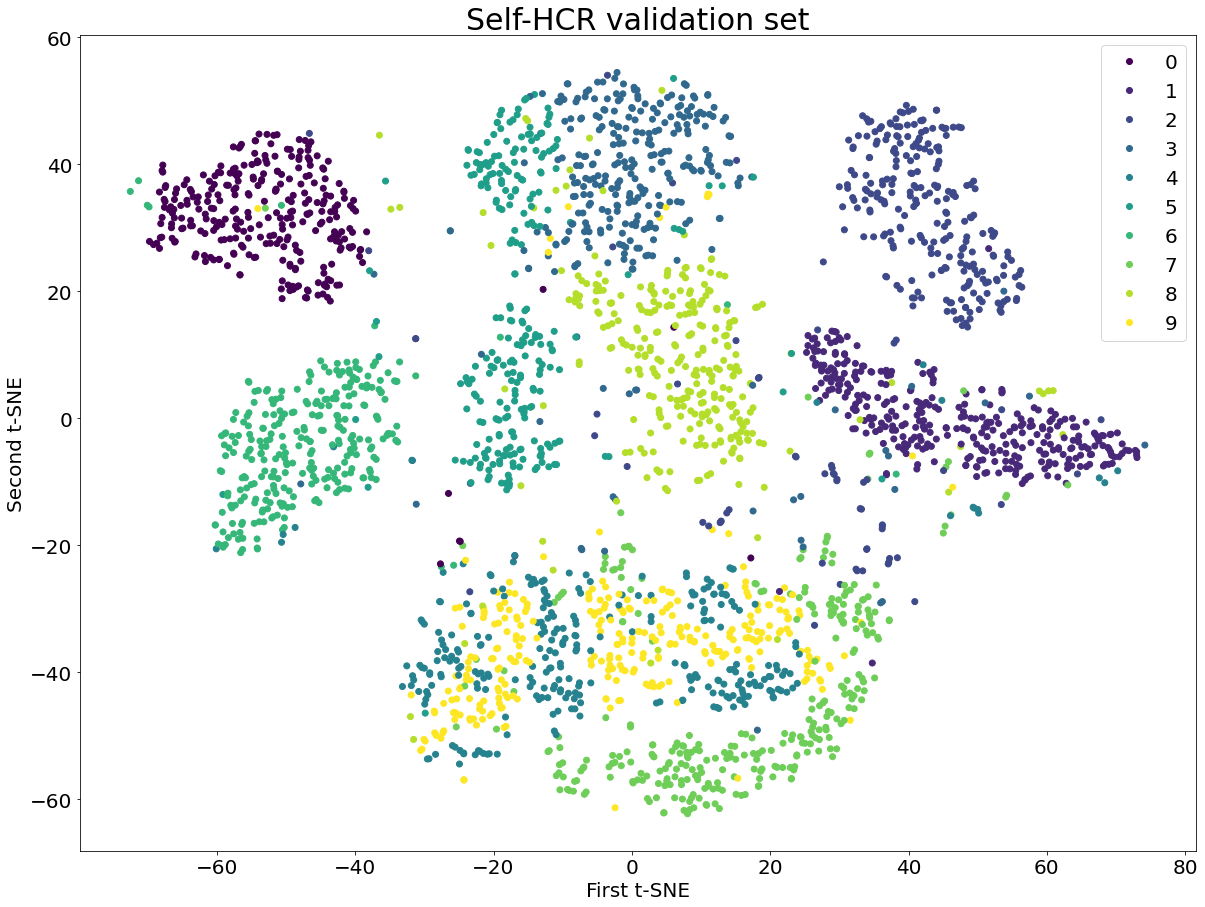

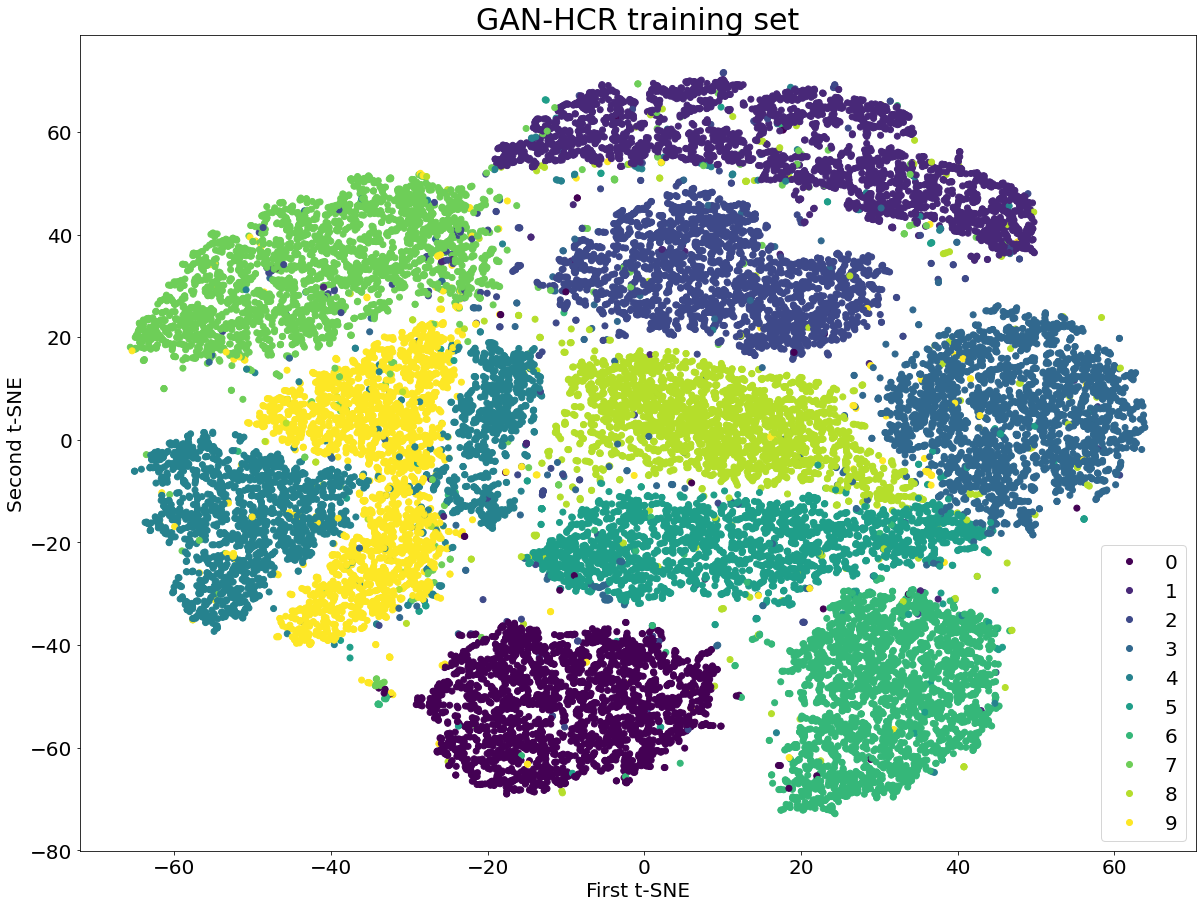

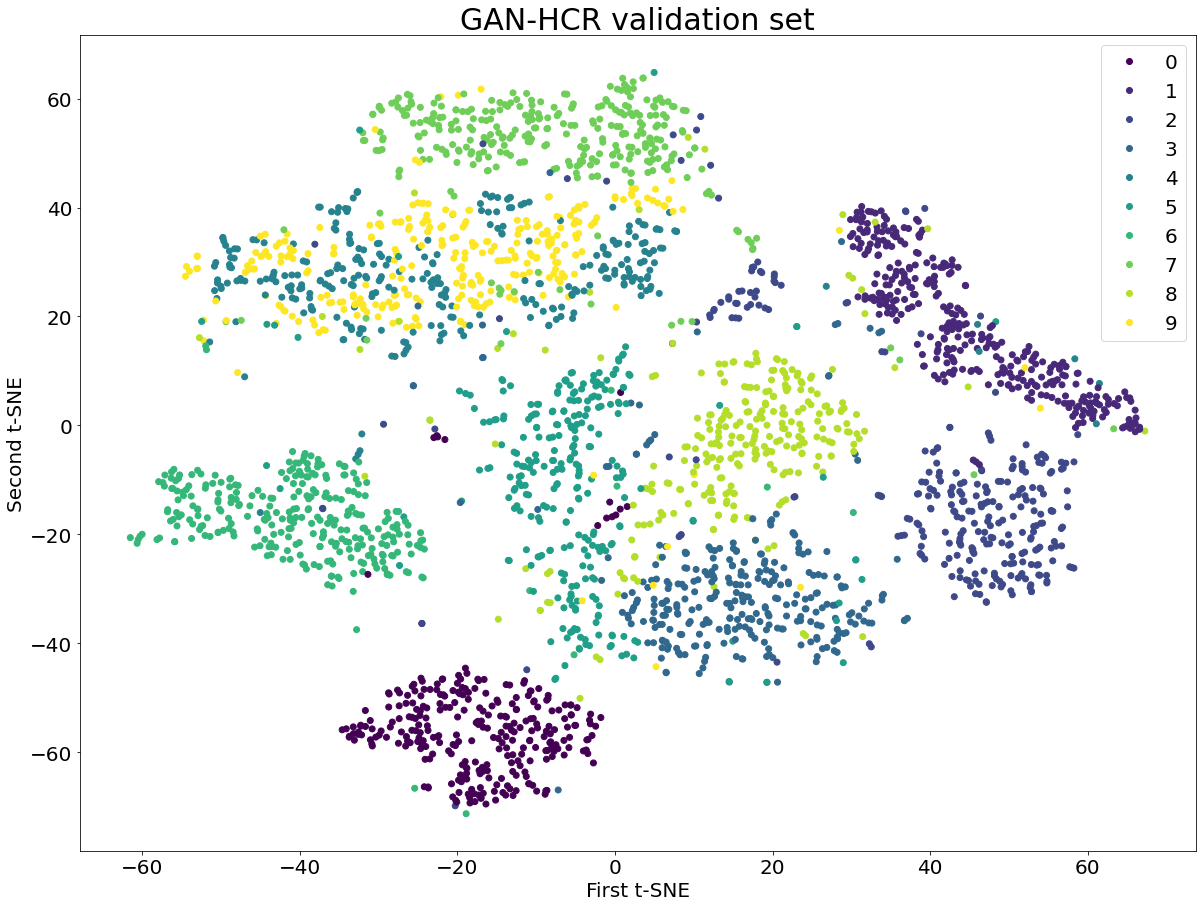

In [135]:
if plot:
	plt.rcParams['figure.figsize'] = [20, 15]
	fig = plt.figure()
	scatter = plt.scatter(x_train_tsne_results[:,0], x_train_tsne_results[:,1], c=np.argmax(y_train, axis=1))
	handles, _ = scatter.legend_elements(prop='colors')
	plt.legend(handles, np.unique(np.argmax(y_train[:10000], axis=1)), prop = { "size": 20 }, loc="upper right")
	plt.title("Self-HCR training set", fontsize=30)
	plt.xlabel("First t-SNE", fontsize=20)
	plt.ylabel("Second t-SNE", fontsize=20)
	plt.yticks(fontsize=20)
	plt.xticks(fontsize=20)
	plt.savefig("./datavis/selfhcr_tr_tsne.png", dpi=300)
	plt.show()

	plt.rcParams['figure.figsize'] = [20, 15]
	fig = plt.figure()
	scatter = plt.scatter(x_val_tsne_res[:,0], x_val_tsne_res[:,1], c=np.argmax(y_val, axis=1))
	handles, _ = scatter.legend_elements(prop='colors')
	plt.legend(handles, np.unique(np.argmax(y_train[:10000], axis=1)), prop = { "size": 20 })
	plt.title("Self-HCR validation set", fontsize=30)
	plt.xlabel("First t-SNE", fontsize=20)
	plt.ylabel("Second t-SNE", fontsize=20)
	plt.yticks(fontsize=20)
	plt.xticks(fontsize=20)
	plt.savefig("./datavis/selfhcr_val_tsne.png", dpi=300)
	plt.show()

	plt.rcParams['figure.figsize'] = [20, 15]
	fig = plt.figure()
	scatter = plt.scatter(gan_train_tsne_results[:,0], gan_train_tsne_results[:,1], c=np.argmax(gan_y_train, axis=1))
	handles, _ = scatter.legend_elements(prop='colors')
	plt.legend(handles, np.unique(np.argmax(y_train[:10000], axis=1)), prop = { "size": 20 })
	plt.title("GAN-HCR training set", fontsize=30)
	plt.xlabel("First t-SNE", fontsize=20)
	plt.ylabel("Second t-SNE", fontsize=20)
	plt.yticks(fontsize=20)
	plt.xticks(fontsize=20)
	plt.savefig("./datavis/ganhcr_tr_tsne.png", dpi=300)
	plt.show()

	plt.rcParams['figure.figsize'] = [20, 15]
	fig = plt.figure()
	scatter = plt.scatter(gan_val_tsne_res[:,0], gan_val_tsne_res[:,1], c=np.argmax(gan_y_val, axis=1))
	handles, _ = scatter.legend_elements(prop='colors')
	plt.legend(handles, np.unique(np.argmax(y_train[:10000], axis=1)), prop = { "size": 20 })
	plt.title("GAN-HCR validation set", fontsize=30)
	plt.xlabel("First t-SNE", fontsize=20)
	plt.ylabel("Second t-SNE", fontsize=20)
	plt.yticks(fontsize=20)
	plt.xticks(fontsize=20)
	plt.savefig("./datavis/ganhcr_val_tsne.png", dpi=300)
	plt.show()


In [136]:
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_val = np.reshape(x_val, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(256)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(256)

In [137]:
def make_htr_model():
    initializer = tf.keras.initializers.HeUniform(seed=42)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1],  kernel_initializer=initializer))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1],  kernel_initializer=initializer))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same',  kernel_initializer=initializer))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(10,  kernel_initializer=initializer))
    model.add(tf.keras.layers.Softmax())
    return model

# Supervised Handwritten character Recognition

In [138]:
super_htr_model = make_htr_model()    
super_htr_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_10 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                                 
 dropout_11 (Dropout)        (None, 7, 7, 64)          0         
                                                                 
 conv2d_17 (Conv2D)          (None, 7, 7, 128)        

In [139]:
epochs = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

super_htr_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['acc'],
)

history = super_htr_model.fit(dataset, epochs=epochs, validation_data=val_dataset, callbacks=[callback])

Epoch 1/100
106/106 [==============================] - 5s 48ms/step - loss: 0.4544 - acc: 0.8629 - val_loss: 0.2061 - val_acc: 0.9383
Epoch 2/100
106/106 [==============================] - 5s 49ms/step - loss: 0.1877 - acc: 0.9439 - val_loss: 0.1279 - val_acc: 0.9610
Epoch 3/100
106/106 [==============================] - 5s 50ms/step - loss: 0.1413 - acc: 0.9569 - val_loss: 0.1043 - val_acc: 0.9683
Epoch 4/100
106/106 [==============================] - 5s 52ms/step - loss: 0.1129 - acc: 0.9660 - val_loss: 0.1010 - val_acc: 0.9717
Epoch 5/100
106/106 [==============================] - 5s 50ms/step - loss: 0.0982 - acc: 0.9688 - val_loss: 0.0955 - val_acc: 0.9703
Epoch 6/100
106/106 [==============================] - 5s 50ms/step - loss: 0.0903 - acc: 0.9712 - val_loss: 0.0863 - val_acc: 0.9757
Epoch 7/100
106/106 [==============================] - 5s 49ms/step - loss: 0.0781 - acc: 0.9741 - val_loss: 0.0820 - val_acc: 0.9733
Epoch 8/100
106/106 [==============================] - 5s 50ms

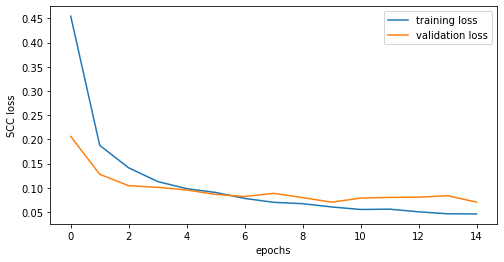

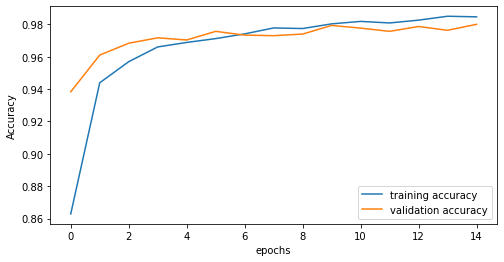

In [144]:
tr_loss = history.history['loss']
val_loss = history.history['val_loss']

tr_acc = history.history['acc']
val_acc = history.history['val_acc']


fig = plt.figure(figsize=(8, 4))

plt.plot(tr_loss, label="training loss")
plt.plot(val_loss, label="validation loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("SCC loss")
if aug:
	plt.savefig("./results/super_hcr_loss_aug.png", dpi=300)
else:
	plt.savefig("./results/super_hcr_loss.png", dpi=300)
plt.show()


fig = plt.figure(figsize=(8, 4))

plt.plot(tr_acc, label="training accuracy")
plt.plot(val_acc, label="validation accuracy")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("Accuracy")
if aug:
	plt.savefig("./results/super_hcr_acc_aug.png", dpi=300)
else:
	plt.savefig("./results/super_hcr_acc.png", dpi=300)
plt.show()

313/313 [==============================] - 1s 3ms/step
Test accuracy: 0.9871


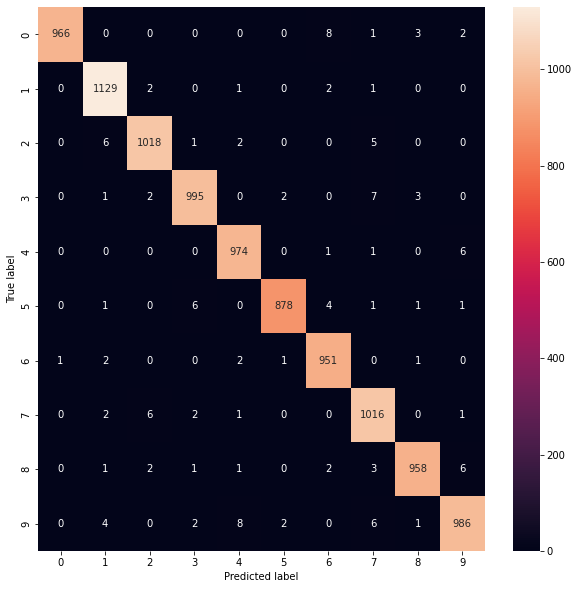

In [141]:
y_pred = super_htr_model.predict(x_test)

y_pred = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1)

accuracy = accuracy_score(y_true, y_pred)
conf_mat = confusion_matrix(y_true, y_pred)

print("Test accuracy:", accuracy)

fig = plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='g')
plt.ylabel("True label")
plt.xlabel("Predicted label")
if aug:
	plt.savefig('super_hcr_confmat_aug.png')
plt.show()

# Self-supervised handwritten character recognition

In [142]:
htr_model = make_htr_model()   
mnist_gen = tf.keras.models.load_model("mnist_gan.keras")
boundaries = [1000, 3000, 5000]
values = [1e-3, 3e-4, 1e-4, 1e-5]

learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

optimizer = tf.keras.optimizers.Adam(learning_rate_fn, beta_1=0.9)
mnist_gen.summary()

OSError: No file or directory found at mnist_gan.keras

In [ ]:
import tensorflow as tf

# Load the pre-trained model without the top dense layers
model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Define input layer
input_data = tf.keras.Input(shape=(28, 28, 3))

# Resize the input to match the input shape of the pre-trained VGG model
resized_input = tf.keras.layers.Resizing(32, 32)(input_data)

# Pass the resized input through the pre-trained model up to the desired layer
desired_layer_name = 'block3_conv1'  # Example: Output from block3_conv1 layer
desired_layer_output = tf.keras.models.Sequential(model.layers[:12])(resized_input)

# Create a new model with input and output up to the desired layer
vgg_model = tf.keras.Model(inputs=input_data, outputs=desired_layer_output)

# Summary of the modified VGG model
vgg_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 32, 32, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 4, 4, 512)         2915648   
                                                                 
Total params: 2,915,648
Trainable params: 2,915,648
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

In [ ]:
def save_images(epoch, imgs, labels, pred_labels, true_imgs, loss_dir, plot=False):
    labels_numbers = np.argmax(labels, axis=1)
    pred_labels_numbers = np.argmax(pred_labels, axis=1)

    fig = plt.figure(figsize=(16, 8))
    plot_idx = 1
    for i in range(imgs.shape[0]):
        # print(losses[i])
        fig.add_subplot(4, 8, plot_idx )
        pred_str = ""
        # print(pred_labels[i])
        for j in pred_labels[i]:
            pred_str += "," + str(j)[:4]
        plt.title(f"gt: {labels_numbers[i]}, \npred: {pred_labels_numbers[i]}\n" + pred_str, fontsize=6.5)
        plt.imshow(true_imgs[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        fig.add_subplot(4, 8, plot_idx + 1)
        plt.imshow(imgs[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
 
        plot_idx += 2
    dir_path = './synth_imgs/' + loss_dir +'/'
    os.makedirs(dir_path, exist_ok=True)
    plt.savefig(dir_path + 'images_at_epoch_{:04d}.png'.format(epoch))
    if plot:
        plt.show()
    plt.close()


In [ ]:
@tf.function
def train_step(data):
    images, one_hot_labels = data

    random_latent_vectors = tf.random.normal(
        shape=(tf.shape(images)[0], latent_dim), seed=1337
    )
    # random_label_noise = tf.random.normal(shape=(tf.shape(images)[0], 10), mean=0, stddev=0.2)

    with tf.GradientTape() as tape:
        pred_labels = htr_model(images, training=True)

        random_vector_labels = tf.concat(
            [random_latent_vectors, pred_labels], axis=-1
        )

        gen_imgs = mnist_gen(random_vector_labels, training=False)
        # loss_mse = tf.reduce_mean((gen_imgs - images) ** 2)
        # loss_ssim = 1 - tf.reduce_mean(tf.image.ssim(images, gen_imgs, 1, filter_size=7))
        # loss = 10*loss_mse + loss_ssim #- 0.1*tf.reduce_mean(tf.reduce_max(pred_labels, axis=1))

        images_in = tf.concat([images] * 3, axis=-1)
        images_gen = tf.concat([gen_imgs] * 3, axis=-1)

        loss = tf.reduce_mean((vgg_model(images_in) - vgg_model(images_gen))**2)
        # loss = tf.keras.losses.BinaryCrossentropy()(images, gen_imgs)
        
    grads = tape.gradient(loss, htr_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, htr_model.trainable_weights))
    
    return loss

In [ ]:


def validate(data):
    val_losses = []
    accuracies = []
    for image_batch in data:
        x_val, y_val = image_batch
        # print(x_val.shape, y_val.shape, tf.shape(x_val))
        y_preds = htr_model.predict(x_val, verbose=0)
        # print(tf.shape(y_preds))
        y_preds_one_hot = tf.keras.utils.to_categorical(np.argmax(y_preds, axis=1), num_classes)
        accuracy = accuracy_score(y_true=y_val, y_pred=y_preds_one_hot)
        accuracies.append(accuracy)

        random_latent_vectors = tf.random.normal(
            shape=(tf.shape(x_val)[0], latent_dim), seed=1337
        )
        # print(tf.shape(random_latent_vectors))

        random_vector_labels = tf.concat(
                [random_latent_vectors, y_preds], axis=1
            )
        
        synth_imgs = mnist_gen(random_vector_labels, training=False)

        images_in = tf.concat([x_val] * 3, axis=-1)
        images_gen = tf.concat([synth_imgs] * 3, axis=-1)

        val_loss = tf.reduce_mean((vgg_model(images_in) - vgg_model(images_gen))**2)
        # val_loss = tf.keras.losses.BinaryCrossentropy()(x_val, synth_imgs)
        val_losses.append(val_loss)
    np.set_printoptions(suppress=True, precision=4)
    # print(np.round(y_preds[:16], 4))
    return np.mean(val_losses), np.mean(accuracies), synth_imgs[:16], x_val[:16], y_val[:16], y_preds[:16]

In [ ]:
from tqdm import tqdm

g_loss = []
val_losses = []
accuracies = []
all_batch_losses = []

for epoch in tqdm(range(100)):
    batch_losses = []
    for batch in dataset:
        loss = train_step(batch)
        batch_losses.append(loss)
        all_batch_losses.append(loss)

    g_loss.append(np.mean(batch_losses))
    
    val_loss, acc, synth_imgs, x_val, y_val, y_preds = validate(val_dataset)
    save_images(epoch, synth_imgs, y_val, y_preds, x_val, 'vgg')
    val_losses.append(val_loss)
    print(acc)
    accuracies.append(acc)


  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [02:14<21:14, 14.01s/it]

In [ ]:
import glob
# Make gif
dir_path = './results/vgg/'
os.makedirs(dir_path)
with imageio.get_writer(dir_path + '/anims.gif', mode='I') as writer:
    filenames = glob.glob('./synth_imgs/vgg/*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    

C:\Users\Lisa\AppData\Local\Temp\ipykernel_6980\525499271.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:
np.save('./train_losses_batch_vgg.npy', all_batch_losses)
np.save('./train_losses_epoch_vgg.npy', g_loss)
np.save('./validation_losses_vgg.npy', val_losses)
np.save('./validation_acc_vgg.npy', accuracies)


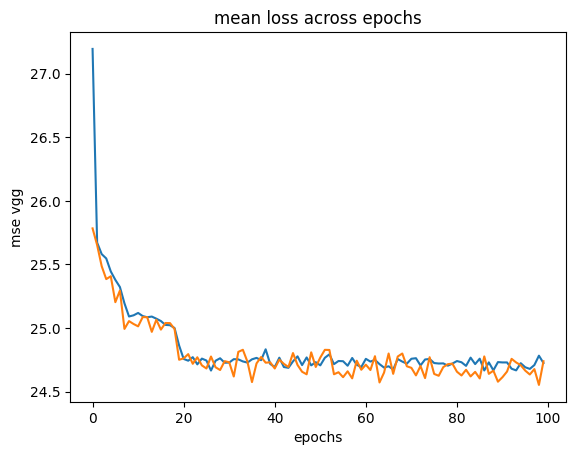

In [ ]:
from matplotlib import pyplot as plt
# htr_model.save("htr_model_vgg.keras")

plt.plot(g_loss, label = "training loss")
plt.plot(val_losses, label = "validation loss")
plt.xlabel("epochs")
plt.ylabel("mse vgg")
plt.title("mean loss across epochs")
plt.savefig("MeanvggEpochs.png", dpi=300, bbox_inches="tight")
plt.show()


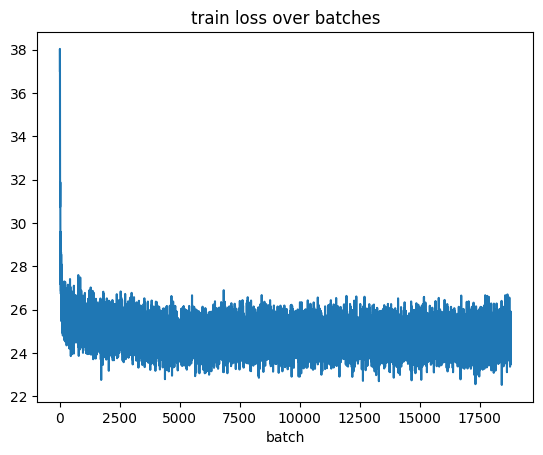

In [ ]:


plt.plot(all_batch_losses)
plt.xlabel("batch")
plt.title("train loss over batches")
plt.show()

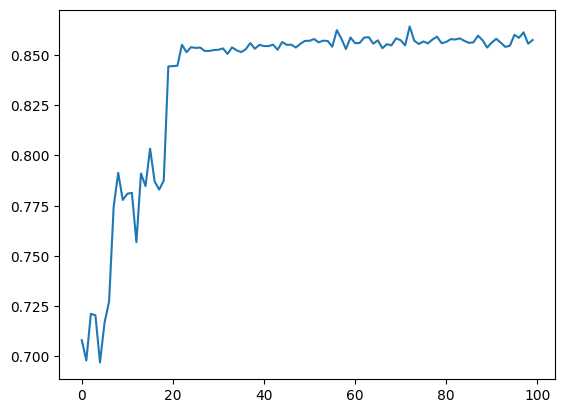

In [ ]:
plt.plot(accuracies)
plt.show()

In [ ]:
g_loss[-1]
accuracies[-1]

0.8575109232522797

In [ ]:
data = list(dataset.take(100))
images, one_hot_labels = data[0]

In [ ]:
images.shape

TensorShape([256, 28, 28, 1])

In [ ]:
pred_labels = htr_model(images[:5], training=False)
print(tf.one_hot(tf.argmax(pred_labels, axis=1), 10))
one_hot_labels[:5]

tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(5, 10), dtype=float32)


<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

tf.Tensor([5], shape=(1,), dtype=int64) [[0.    0.002 0.    0.    0.    0.998 0.    0.    0.    0.   ]]
tf.Tensor([2], shape=(1,), dtype=int64) [[0.    0.079 0.819 0.06  0.    0.    0.002 0.038 0.    0.   ]]
tf.Tensor([1], shape=(1,), dtype=int64) [[0.    0.992 0.001 0.    0.    0.001 0.001 0.005 0.    0.   ]]
tf.Tensor([0], shape=(1,), dtype=int64) [[0.364 0.039 0.001 0.019 0.001 0.033 0.393 0.001 0.001 0.148]]
tf.Tensor([9], shape=(1,), dtype=int64) [[0.    0.003 0.    0.    0.001 0.    0.    0.002 0.    0.993]]
tf.Tensor([4], shape=(1,), dtype=int64) [[0.    0.013 0.    0.    0.977 0.    0.    0.002 0.    0.008]]
tf.Tensor([2], shape=(1,), dtype=int64) [[0.    0.003 0.986 0.002 0.    0.    0.    0.005 0.    0.004]]
tf.Tensor([8], shape=(1,), dtype=int64) [[0.    0.002 0.    0.    0.    0.003 0.    0.001 0.989 0.005]]
tf.Tensor([5], shape=(1,), dtype=int64) [[0.004 0.26  0.    0.    0.    0.727 0.    0.001 0.006 0.001]]
tf.Tensor([8], shape=(1,), dtype=int64) [[0.002 0.001 0.    0.00

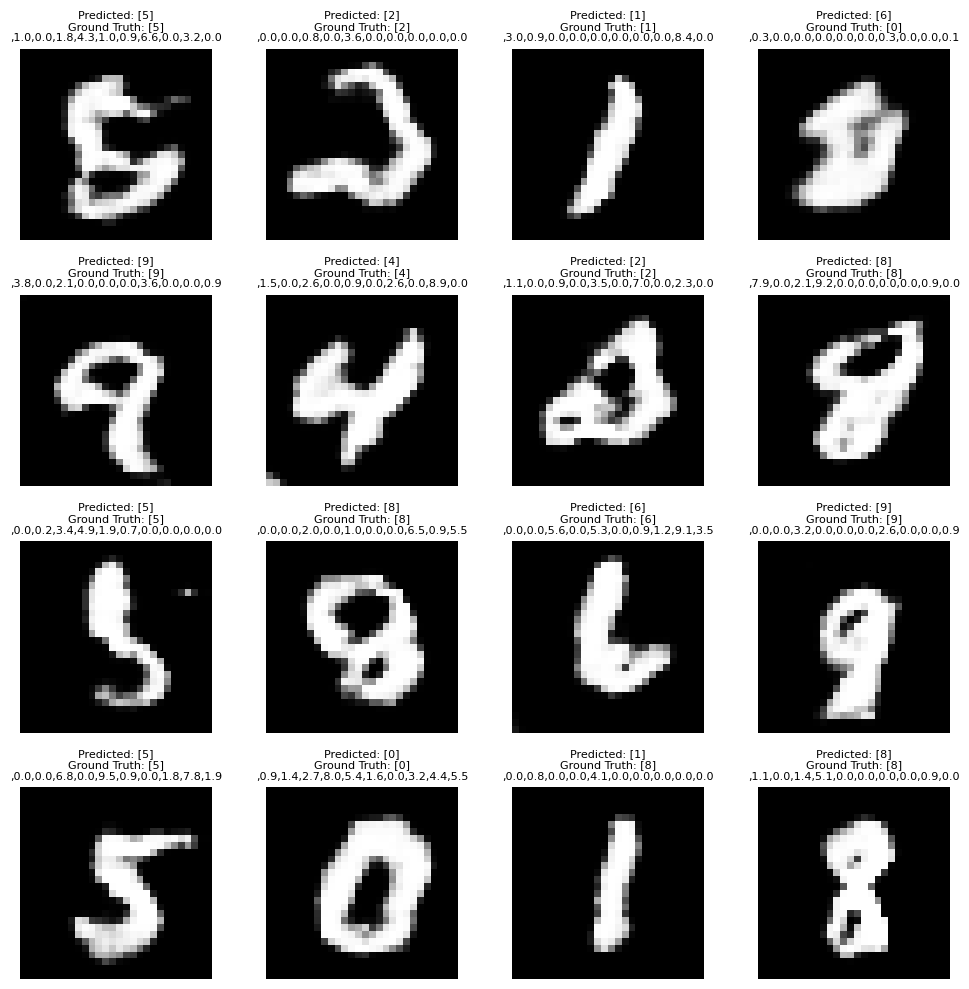

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

# Flatten the axs array to iterate over all subplots
axs = axs.flatten()

for i in range(16):
    pred = htr_model(images[i:(i+1)], training=False)

    pred_label = tf.argmax(pred, axis=1)
    
    gt_label = tf.argmax(one_hot_labels[i:(i+1)], axis=1)

    random_latent_vectors = tf.random.normal(
        shape=(1, latent_dim), seed=21
    )

    random_vector_labels = tf.concat(
        [random_latent_vectors, pred], axis=-1
    )
    gen_img = mnist_gen(random_vector_labels, training=False)
    # Plot image
    axs[i].imshow(tf.squeeze(gen_img), cmap='gray')
    axs[i].axis('off')  # Turn off axis
    
    # Add text above each pair of plots indicating predicted class and ground truth
    print(gt_label, np.round(pred.numpy(), 3))
    pred_str = ""
    for j in pred[0]:
        pred_str += "," + str(j.numpy())[:3]
    text = f'Predicted: {pred_label}\nGround Truth: {gt_label}\n' + pred_str
    axs[i].set_title(text, fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
def compute_accuracy(true_labels, predicted_labels):
    """
    Compute accuracy between true labels and predicted labels.

    Args:
    true_labels (list): List of true labels.
    predicted_labels (list): List of predicted labels.

    Returns:
    float: Accuracy as a value between 0 and 1.
    """
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Length of true labels and predicted labels must be the same.")

    correct_predictions = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    total_samples = len(true_labels)

    accuracy = correct_predictions / total_samples if total_samples != 0 else 0

    return accuracy


In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(256)

acc = []
for batch in tqdm(test_dataset):
    images, one_hot_labels = batch
    preds = htr_model(images, training=False)
    pred_labels = tf.argmax(preds, axis=1)
    gt_labels = tf.argmax(one_hot_labels, axis=1)
    acc.append(compute_accuracy(gt_labels, pred_labels))

print("Accuracy: ", np.mean(acc)*100)

100%|██████████| 40/40 [00:10<00:00,  3.94it/s]

Accuracy:  86.103515625
